In [157]:
import statsmodels.api as sm
import numpy as np
from statsmodels.gam.api import GLMGam, BSplines
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pygam import GAM, s, f, LinearGAM
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [49]:
data_path = '../../Data/KORA_S3_S4/KORA_Noise_noMissing_median.csv'
KORA_Noise_noMissing = pd.read_csv(data_path)

In [141]:
X_mini = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org']]

# noise cut-off
X_mini_test = X_mini['lden_org']
X_mini_test[X_mini_test<=40] = 40
X_mini['lden_org'] = X_mini_test

Y_SBP = KORA_Noise_noMissing['bp_syst']

Data_numeric = KORA_Noise_noMissing[['age', 'bmi', 'lden_org', 'bp_syst']]
Data_categoric = KORA_Noise_noMissing[['sex', 'smoking']]
Data = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org', 'bp_syst']]
print('Data description \n')
print('Sex: Female = 0, Male = 1 \nSmoking: Current = 1, Ex-smoker = 2, Never-smoker =3 \n ')
X_mini.describe()

Data description 

Sex: Female = 0, Male = 1 
Smoking: Current = 1, Ex-smoker = 2, Never-smoker =3 
 


,sex,age,bmi,smoking,lden_org
count,9116.000000,9116.000000,9116.000000,9116.000000,9116.000000
mean,0.492979,49.555836,27.115082,2.169263,54.750581
std,0.499978,14.033439,4.594119,0.810235,6.498166
min,0.000000,24.000000,15.840000,1.000000,40.000000
25%,0.000000,37.000000,23.940000,1.000000,50.600000
50%,0.000000,50.000000,26.580000,2.000000,53.900000
75%,1.000000,61.000000,29.630000,3.000000,58.500000
max,1.000000,75.000000,56.930000,3.000000,77.500000


In [142]:
Data_categoric['smoking']= Data_categoric['smoking'].map({1.0:'Current', 2.0:'Ex_smoker', 3.0:'Never_smoker'})
Data_categoric['sex']= Data_categoric['sex'].map({0.0:'female', 1.0:'male'})
print(Data_categoric.dtypes)
Data_categoric.head()

sex        object
smoking    object
dtype: object


,sex,smoking
0,female,Ex_smoker
1,male,Ex_smoker
2,male,Never_smoker
3,female,Current
4,female,Ex_smoker


In [143]:
Data_numeric_scaled = pd.DataFrame(scale(Data_numeric), index=Data_numeric.index,
                           columns=Data_numeric.columns)
# Data_numeric.head()
Data_numeric_scaled.head()

,age,bmi,lden_org,bp_syst
0,-1.322331,-1.779564,-2.083140,-1.256215
1,-0.680971,0.005424,0.072704,0.637412
2,0.673013,0.702005,0.072704,1.712172
3,0.886799,-1.666370,-1.202584,-1.102678
4,0.886799,0.900095,-0.534576,-0.897961


In [144]:
Data = pd.concat([Data_numeric, Data_categoric], axis= 1)
Data_scaled = pd.concat([Data_numeric_scaled, Data_categoric], axis= 1)
print(Data.head())
print(Data_scaled.head())

    age    bmi  lden_org  bp_syst     sex       smoking
0  31.0  18.94      41.0    106.0  female     Ex_smoker
1  40.0  27.14      55.2    143.0    male     Ex_smoker
2  59.0  30.34      55.2    164.0    male  Never_smoker
3  62.0  19.46      46.8    109.0  female       Current
4  62.0  31.25      51.2    113.0  female     Ex_smoker
        age       bmi  lden_org   bp_syst     sex       smoking
0 -1.322331 -1.779564 -2.083140 -1.256215  female     Ex_smoker
1 -0.680971  0.005424  0.072704  0.637412    male     Ex_smoker
2  0.673013  0.702005  0.072704  1.712172    male  Never_smoker
3  0.886799 -1.666370 -1.202584 -1.102678  female       Current
4  0.886799  0.900095 -0.534576 -0.897961  female     Ex_smoker


In [145]:
# make the formular
variables = Data.columns.drop('bp_syst')
formula = 'bp_syst ~ ' + ' + '.join(variables)
print(formula)

bp_syst ~ age + bmi + lden_org + sex + smoking


## Statsmodels

In [161]:
# create spline basis for age, bmi, lden_org ----- scaled data
x_spline = Data_scaled[['age', 'bmi', 'lden_org']]

# 2,3,4
bs = BSplines(x_spline, df=[9, 9, 9], degree=[3, 3, 3])

# penalization weight
alpha = np.array([5.011872336272722, 125.89254117941663, 630.957344480193])

gam_scaled = GLMGam.from_formula('bp_syst ~ sex + smoking', data = Data_scaled, smoother = bs, alpha = alpha)
res_scaled = gam_scaled.fit()

print(res_scaled.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                bp_syst   No. Observations:                 9116
Model:                         GLMGam   Df Residuals:                  9102.98
Model Family:                Gaussian   Df Model:                        12.02
Link Function:               identity   Scale:                         0.73127
Method:                         PIRLS   Log-Likelihood:                -11502.
Date:                Fri, 18 Jun 2021   Deviance:                       6656.7
Time:                        11:44:07   Pearson chi2:                 6.66e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [159]:
unit = 1
res_scaled.change = (np.exp(res_scaled.params * unit)-1) * 100
res_scaled.change.name='Change'

res_scaled.change_LL = (np.exp((res_scaled.params - 1.96 * res_scaled.bse)*unit)-1)*100
res_scaled.change_LL.name='Change_LL'

res_scaled.change_UL = (np.exp((res_scaled.params + 1.96 * res_scaled.bse)*unit)-1)*100
res_scaled.change_UL.name='Change_UL'

summary = pd.concat([res_scaled.change, res_scaled.change_LL, res_scaled.change_UL, res_scaled.params,
                     res_scaled.bse, res_scaled.tvalues, res_scaled.pvalues],
                    names=['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'], axis = 1)
summary.to_excel('output/GAM/GAM_scaled_results_python.xlsx',
                 header= ['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'])
print(summary)

                             Change   Change_LL   Change_UL         0  \
Intercept                -73.469215  -80.950556  -63.049705 -1.326864   
sex[T.male]               50.675494   45.162031   56.398366  0.409958   
smoking[T.Ex_smoker]      -2.317784   -6.881760    2.469885 -0.023451   
smoking[T.Never_smoker]    7.207162    2.398705   12.241416  0.069593   
age_s0                    -4.793269  -16.475536    8.522954 -0.049120   
age_s1                    19.492182    5.383961   35.489134  0.178081   
age_s2                   110.434786   85.543456  138.665378  0.744006   
age_s3                   164.217131  133.454288  199.033668  0.971601   
age_s4                   246.659093  204.115405  295.154355  1.243172   
bmi_s0                    16.114425    6.653165   26.414998  0.149406   
bmi_s1                    42.955410   24.623714   63.983632  0.357363   
bmi_s2                   165.940265  129.165062  208.616959  0.978102   
bmi_s3                   193.921989  130.864067  27

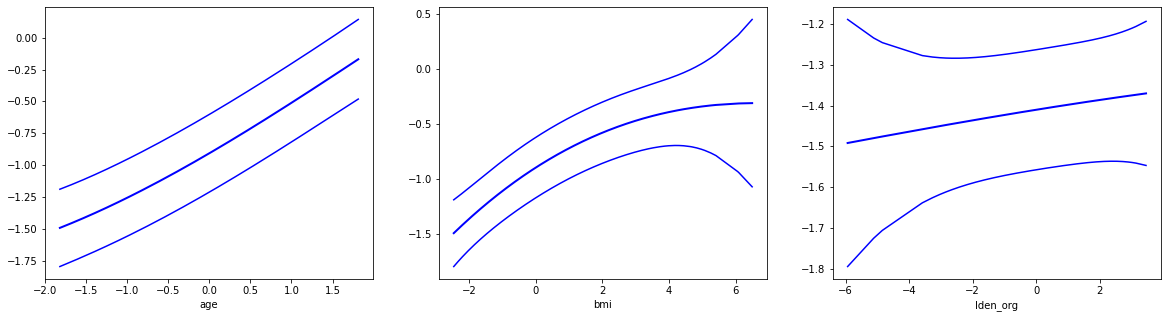

In [162]:
# plot smooth components


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
res_bs_scaled.plot_partial(0, plot_se = True, ax = ax1)
res_bs_scaled.plot_partial(1, plot_se = True, ax = ax2)
res_bs_scaled.plot_partial(2, plot_se = True, ax = ax3)
plt.savefig('output/GAM/GAM_scaled_python.pdf')
plt.show()

In [108]:
# create spline basis for age, bmi, lden_org
x_spline = Data[['age', 'bmi', 'lden_org']]

# 2,3,4
bs = BSplines(x_spline, df=[4, 4, 4], degree=[3, 3, 3])

# penalization weight
alpha = np.array([1.0, 5.011872336272722, 15848.931924611108])

gam = GLMGam.from_formula('bp_syst ~ sex + smoking', data = Data, smoother = bs, alpha = alpha)
res = gam.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                bp_syst   No. Observations:                 9116
Model:                         GLMGam   Df Residuals:                  9103.85
Model Family:                Gaussian   Df Model:                        11.15
Link Function:               identity   Scale:                          279.70
Method:                         PIRLS   Log-Likelihood:                -38607.
Date:                Thu, 17 Jun 2021   Deviance:                   2.5463e+06
Time:                        14:13:12   Pearson chi2:                 2.55e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [109]:
unit = 1
res.change = (np.exp(res.params * unit)-1) * 100
res.change.name='Change'

res.change_LL = (np.exp((res.params - 1.96 * res.bse)*unit)-1)*100
res.change_LL.name='Change_LL'

res.change_UL = (np.exp((res.params + 1.96 * res.bse)*unit)-1)*100
res.change_UL.name='Change_UL'

summary = pd.concat([res.change, res.change_LL, res.change_UL, res.params,
                     res.bse, res.tvalues, res.pvalues],
                    names=['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'], axis = 1)
summary.to_excel('output/GAM/GAM_results_python.xlsx',
                 header= ['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'])
print(summary)

                               Change     Change_LL     Change_UL           0  \
Intercept                3.960806e+46  6.243446e+41  2.512713e+51  102.690192   
sex[T.male]              2.852463e+05  1.369665e+05  5.939368e+05    7.956289   
smoking[T.Ex_smoker]    -3.760131e+01 -7.551742e+01  5.903542e+01   -0.471626   
smoking[T.Never_smoker]  2.793551e+02  5.466019e+01  8.304934e+02    1.333302   
age_s0                   1.256229e+02 -9.756804e+01  2.083193e+04    0.813695   
age_s1                   1.503863e+09  1.084301e+08  2.085771e+10   16.526133   
age_s2                   1.685766e+12  1.233926e+11  2.303063e+13   23.548071   
bmi_s0                   4.858479e+09  6.094732e+05  3.872352e+13   17.698821   
bmi_s1                   6.281169e+11  1.060457e+08  3.720380e+15   22.560822   
bmi_s2                   2.153654e+12  3.458823e+05  1.340596e+19   23.793017   
lden_org_s0              2.795528e+02 -9.999995e+01  3.180210e+09    1.333823   
lden_org_s1              5.9

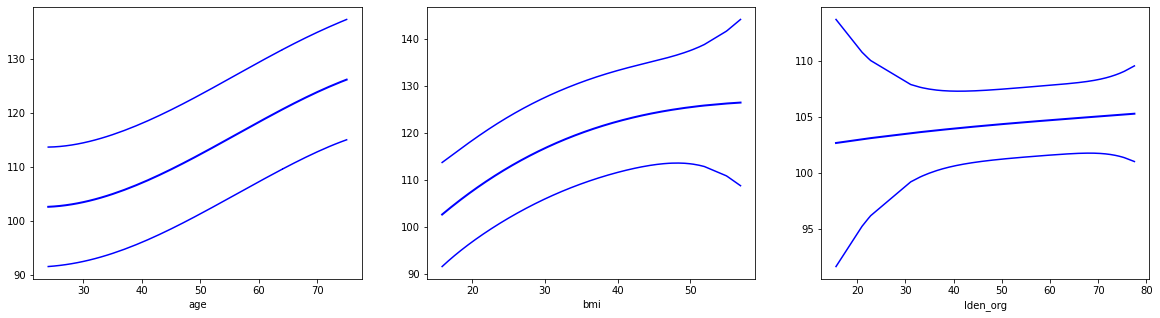

In [110]:
# plot smooth components


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
res_bs.plot_partial(0, plot_se = True, ax = ax1)
res_bs.plot_partial(1, plot_se = True, ax = ax2)
res_bs.plot_partial(2, plot_se = True, ax = ax3)
plt.savefig('output/GAM/GAM_python.pdf')
plt.show()

In [111]:
# gam.select_penweight_kfold()[0]

In [112]:
# gam_scaled.select_penweight_kfold()[0]

## Prediction with Statsmodels

### Train - test data split

In [11]:
# original data
X_train, X_test, y_train, y_test = train_test_split(Data.drop(['bp_syst'], axis = 1),
                                Data['bp_syst'], test_size=0.2, random_state = 10)

train_Data = pd.concat([X_train, y_train], axis = 1)

# scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    Data_scaled.drop(['bp_syst'], axis = 1), Data_scaled['bp_syst'], test_size=0.2, random_state = 10)


In [12]:


# create spline basis for age, bmi, lden_org
x_spline = train_Data[['age', 'bmi', 'lden_org']]

# 2,3,4
bs = BSplines(x_spline, df=[4, 4, 4], degree=[3, 3, 3])

# penalization weight
alpha = np.array([1.0, 5.011872336272722, 15848.931924611108])

gam_model = GLMGam.from_formula('bp_syst ~ sex + smoking', data = train_Data , smoother = bs, alpha = alpha)
res_train = gam_model.fit()

print(res_train.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                bp_syst   No. Observations:                 7292
Model:                         GLMGam   Df Residuals:                  7279.90
Model Family:                Gaussian   Df Model:                        11.10
Link Function:               identity   Scale:                          276.32
Method:                         PIRLS   Log-Likelihood:                -30837.
Date:                Wed, 14 Jul 2021   Deviance:                   2.0116e+06
Time:                        15:56:50   Pearson chi2:                 2.01e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [121]:
#exog = np.ones(X_test.shape[0]),

res_pred = gam_model.predict(res_train.params)
print(np.shape(res_pred))

(7292,)


In [44]:
# Gamma Distribution


# gamGama_bs = GLMGam.from_formula('bp_syst ~ sex + smoking', data=X_mini,
#                              smoother=bs, alpha=alpha,
#                              family=sm.families.Gamma())

# res_bs = gamGama_bs.fit()

# print(res_bs.summary())

PatsyError: Error evaluating factor: NameError: name 'bp_syst' is not defined
    bp_syst ~ sex + smoking
    ^^^^^^^

## Pygam

### Train-Test data split

In [146]:
# original data
X_mini['smoking'] = X_mini['smoking']-1            # by Pygam a categorical variable has to start with the category 0! 
X_train, X_test, y_train, y_test = train_test_split(X_mini, Y_SBP, test_size = 0.2, random_state = 10)

### Bulding the model

In [147]:
gam_pyGam = GAM(f(0) + s(1) + s(2) + f(3) + s(4)).fit(X_train, y_train)
gam_pyGam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.4676
Link Function:                     IdentityLink Log Likelihood:                                -47684.6703
Number of Samples:                         7292 AIC:                                            95468.2758
                                                AICc:                                           95468.9653
                                                GCV:                                              278.8295
                                                Scale:                                            275.4956
                                                Pseudo R-Squared:                                   0.2733
Feature Function                  Lam

### Grid search for the variable Lambda

In [167]:
lams = np.random.rand(100, 5) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3

# lam = np.logspace(-5, 5, 5)
# lams = [lam] * 5

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)

gam_pyGam_GCV = LinearGAM(f(0) + s(1) + s(2) + f(3) + s(4)).gridsearch(X_train_np, y_train_np, lam = lams)
gam_pyGam_GCV.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.9451
Link Function:                     IdentityLink Log Likelihood:                                -47684.7577
Number of Samples:                         7292 AIC:                                            95415.4057
                                                AICc:                                           95415.5569
                                                GCV:                                              276.9972
                                                Scale:                                            275.4971
                                                Pseudo R-Squared:                                   0.2706
Feature Function                  Lam

### Find the effects

In [148]:
# it is not necessary - later!

# unit = 1
# res_scaled.change = (np.exp(res_scaled.params * unit)-1) * 100
# res_scaled.change.name='Change'

# res_scaled.change_LL = (np.exp((res_scaled.params - 1.96 * res_scaled.bse)*unit)-1)*100
# res_scaled.change_LL.name='Change_LL'

# res_scaled.change_UL = (np.exp((res_scaled.params + 1.96 * res_scaled.bse)*unit)-1)*100
# res_scaled.change_UL.name='Change_UL'

# summary = pd.concat([res_scaled.change, res_scaled.change_LL, res_scaled.change_UL, res_scaled.params,
#                      res_scaled.bse, res_scaled.tvalues, res_scaled.pvalues],
#                     names=['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'], axis = 1)
# summary.to_excel('output/GAM/LR_scaled_results_python.xlsx',
#                  header= ['Change', 'Change_LL', 'Change_UL', 'Estimate', 'SD', 't', 'p'])
# print(summary)

### Partial dependence

<Figure size 432x288 with 0 Axes>

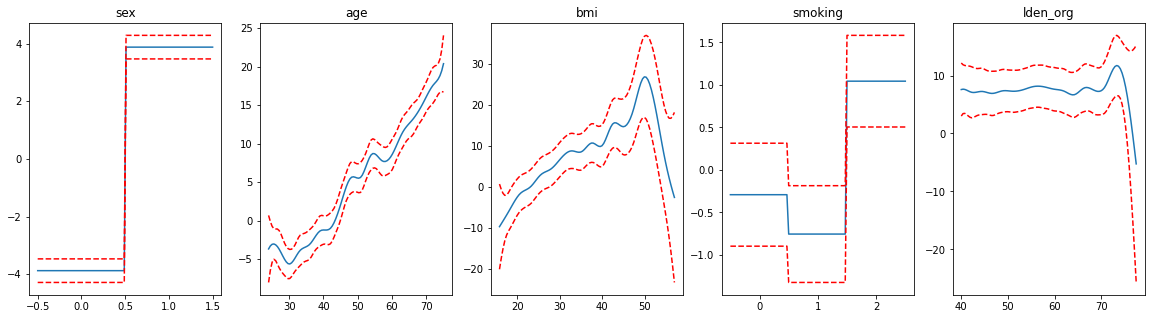

In [149]:

titles = X_train.columns
plt.figure()
fig, axs = plt.subplots(1,len(X_train.columns),figsize=(20, 5))

for i, ax in enumerate(axs):
    XX = gam_pyGam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_pyGam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_pyGam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])

plt.savefig('output/GAM/PartialDependence_pygam.pdf')

### Prediction

<Figure size 432x288 with 0 Axes>

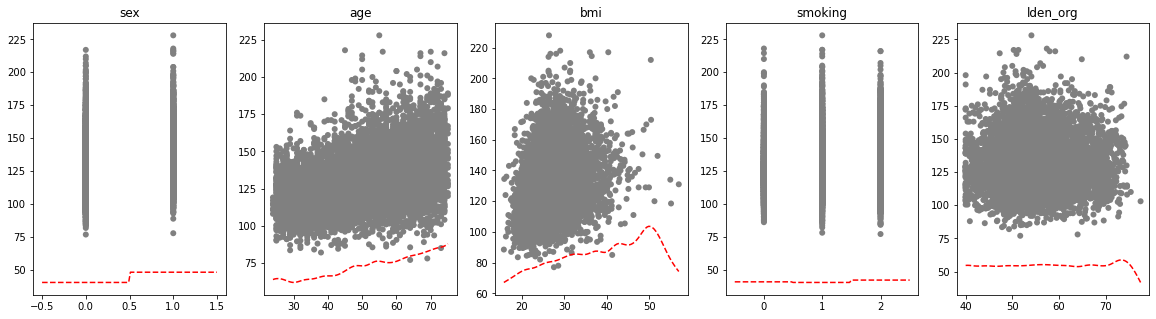

In [150]:
titles = X_train.columns
plt.figure()
fig, axs = plt.subplots(1,len(X_train.columns),figsize=(20, 5))

for i, ax in enumerate(axs):
    XX = gam_pyGam.generate_X_grid(term=i) # generate random numbers
    ax.plot(XX[:, i], gam_pyGam.predict(XX), 'r--') # plot the prediction for the generated sample
    ax.scatter(X_train.iloc[:, i], y_train, facecolor='gray', edgecolors='none')
    ax.set_title('95% prediction interval')
    ax.set_title(titles[i])
    
plt.savefig('output/GAM/Prediction_pygam.pdf')

<Figure size 432x288 with 0 Axes>

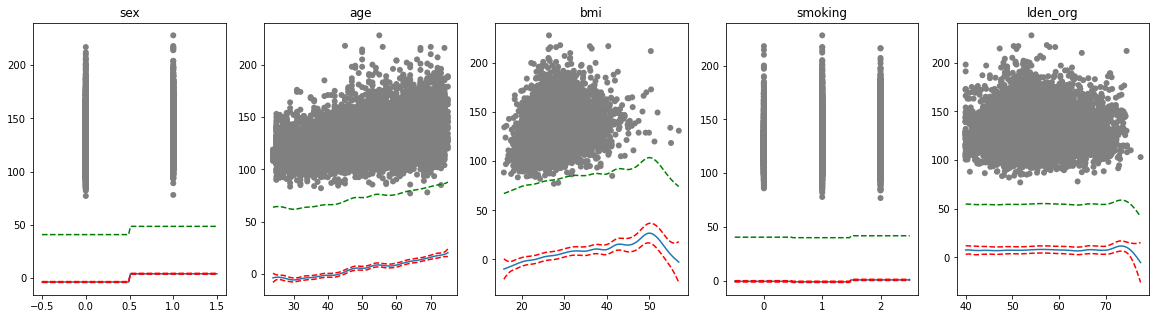

In [151]:

# all together

titles = X_train.columns
plt.figure()
fig, axs = plt.subplots(1,len(X_train.columns),figsize=(20, 5))

for i, ax in enumerate(axs):
    XX = gam_pyGam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_pyGam.predict(XX), 'g--')
    ax.plot(XX[:, i], gam_pyGam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_pyGam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #ax.plot(XX[:, i], gam_pyGam.prediction_intervals(XX, width=.95), color='b', ls='--')
    ax.scatter(X_train.iloc[:, i], y_train, facecolor='gray', edgecolors='none')
    ax.set_title('95% prediction interval')
    ax.set_title(titles[i])

plt.savefig('output/GAM/All_pygam.pdf')

### prediction accuracy

In [152]:
y_pred = gam_pyGam.predict(X_test)
print('Mean squared error (MSE) : %.2f' % mean_squared_error(y_test, y_pred))
print('Mean absolute error (MSE) : %.2f' % mean_absolute_error(y_test, y_pred))
print('R^2: %.2f' % r2_score(y_test, y_pred))

Mean squared error (MSE) : 293.26
Mean absolute error (MSE) : 13.03
R^2: 0.27
